# Import Libraries

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Download Data

In [15]:
# Time Period
start = '2015-10-18'
end   = '2025-10-18'

# Tickers Stocks
tickers = {
    'Energy': ['XOM', 'CVX', 'COP'],
    'Healthcare': ['JNJ', 'PFE', 'MRK'],
    'IT': ['AAPL', 'MSFT', 'GOOGL']
}
all_stocks = [stock for sector in tickers.values() for stock in sector]

# Download stock prices
stocks_daily = yf.download(all_stocks, start=start, end=end)['Close']

# Download market index (S&P 500)
market_daily = yf.download('^GSPC', start=start, end=end)['Close']

# Download risk-free (3-Months T-Bill)
tbill_daily = yf.download('^IRX', start=start, end=end)['Close']


/tmp/ipython-input-3697263343.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stocks_daily = yf.download(all_stocks, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed
/tmp/ipython-input-3697263343.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_daily = yf.download('^GSPC', start=start, end=end)['Close']
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3697263343.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tbill_daily = yf.download('^IRX', start=start, end=end)['Close']
[*********************100%***********************]  1 of 1 completed


# Compute Returns

In [33]:
import pandas as pd

# Convert daily series to month-end prices
stocks_monthly = stocks_daily.resample('ME').last()
market_monthly = market_daily.resample('ME').last()
tbill_monthly = tbill_daily.resample('ME').last()

# Compute monthly returns
stocks_returns = stocks_monthly.pct_change()
market_returns = market_monthly.pct_change()

# Convert annual T-bill rates (%) to monthly risk-free rate
risk_free_monthly = (1 + tbill_monthly['^IRX'] / 100)**(1/12) - 1

# Align indices
stocks_returns = stocks_returns.reindex(risk_free_monthly.index)
market_returns = market_returns.reindex(risk_free_monthly.index)

# Combine all data into a single DataFrame
data = stocks_returns.copy()                        # Stock returns
data['Market_Excess'] = market_returns['^GSPC'] - risk_free_monthly  # Market excess return

# Drop any remaining NaN rows
data = data.dropna()

# Preview the dataset
print(data.head())


Ticker          AAPL       COP       CVX     GOOGL       JNJ       MRK  \
Date                                                                     
2015-11-30 -0.005804  0.013120  0.017114  0.034527  0.009466 -0.030187   
2015-12-31 -0.110228 -0.136170 -0.014893  0.019873  0.014619  0.005027   
2016-01-31 -0.075242 -0.162990 -0.038795 -0.021413  0.016745 -0.040704   
2016-02-29 -0.001287 -0.127596 -0.022802 -0.057963  0.014673 -0.009078   
2016-03-31  0.127211  0.190363  0.143337  0.063690  0.028419  0.062993   

Ticker          MSFT       PFE       XOM  Market_Excess  
Date                                                     
2015-11-30  0.039444 -0.023226 -0.004450       0.000363  
2015-12-31  0.020791 -0.014953 -0.045432      -0.017653  
2016-01-31 -0.007030 -0.055452 -0.001283      -0.050985  
2016-02-29 -0.069789 -0.017111  0.038889      -0.004385  
2016-03-31  0.085496 -0.001011  0.042919       0.065830  


# CAPM

In [39]:
reg_results = {}

for stock in stocks_returns.columns:
    y = data[stock]
    x = data['Market_Excess']

    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    reg_results[stock] = model

    print(f"\n--- {stock} CAPM Regression ---")
    print(f"Alpha (α): {model.params['const']:.4f}")
    print(f"Beta  (β): {model.params['Market_Excess']:.4f}")
    print(f"R-squared: {model.rsquared:.4f}")


--- AAPL CAPM Regression ---
Alpha (α): 0.0111
Beta  (β): 1.2085
R-squared: 0.4311

--- COP CAPM Regression ---
Alpha (α): 0.0017
Beta  (β): 1.1346
R-squared: 0.2209

--- CVX CAPM Regression ---
Alpha (α): 0.0017
Beta  (β): 1.0266
R-squared: 0.3238

--- GOOGL CAPM Regression ---
Alpha (α): 0.0094
Beta  (β): 1.0297
R-squared: 0.4116

--- JNJ CAPM Regression ---
Alpha (α): 0.0041
Beta  (β): 0.5256
R-squared: 0.2422

--- MRK CAPM Regression ---
Alpha (α): 0.0048
Beta  (β): 0.3745
R-squared: 0.0865

--- MSFT CAPM Regression ---
Alpha (α): 0.0135
Beta  (β): 0.9468
R-squared: 0.4986

--- PFE CAPM Regression ---
Alpha (α): -0.0022
Beta  (β): 0.6072
R-squared: 0.1672

--- XOM CAPM Regression ---
Alpha (α): 0.0013
Beta  (β): 0.8881
R-squared: 0.2436


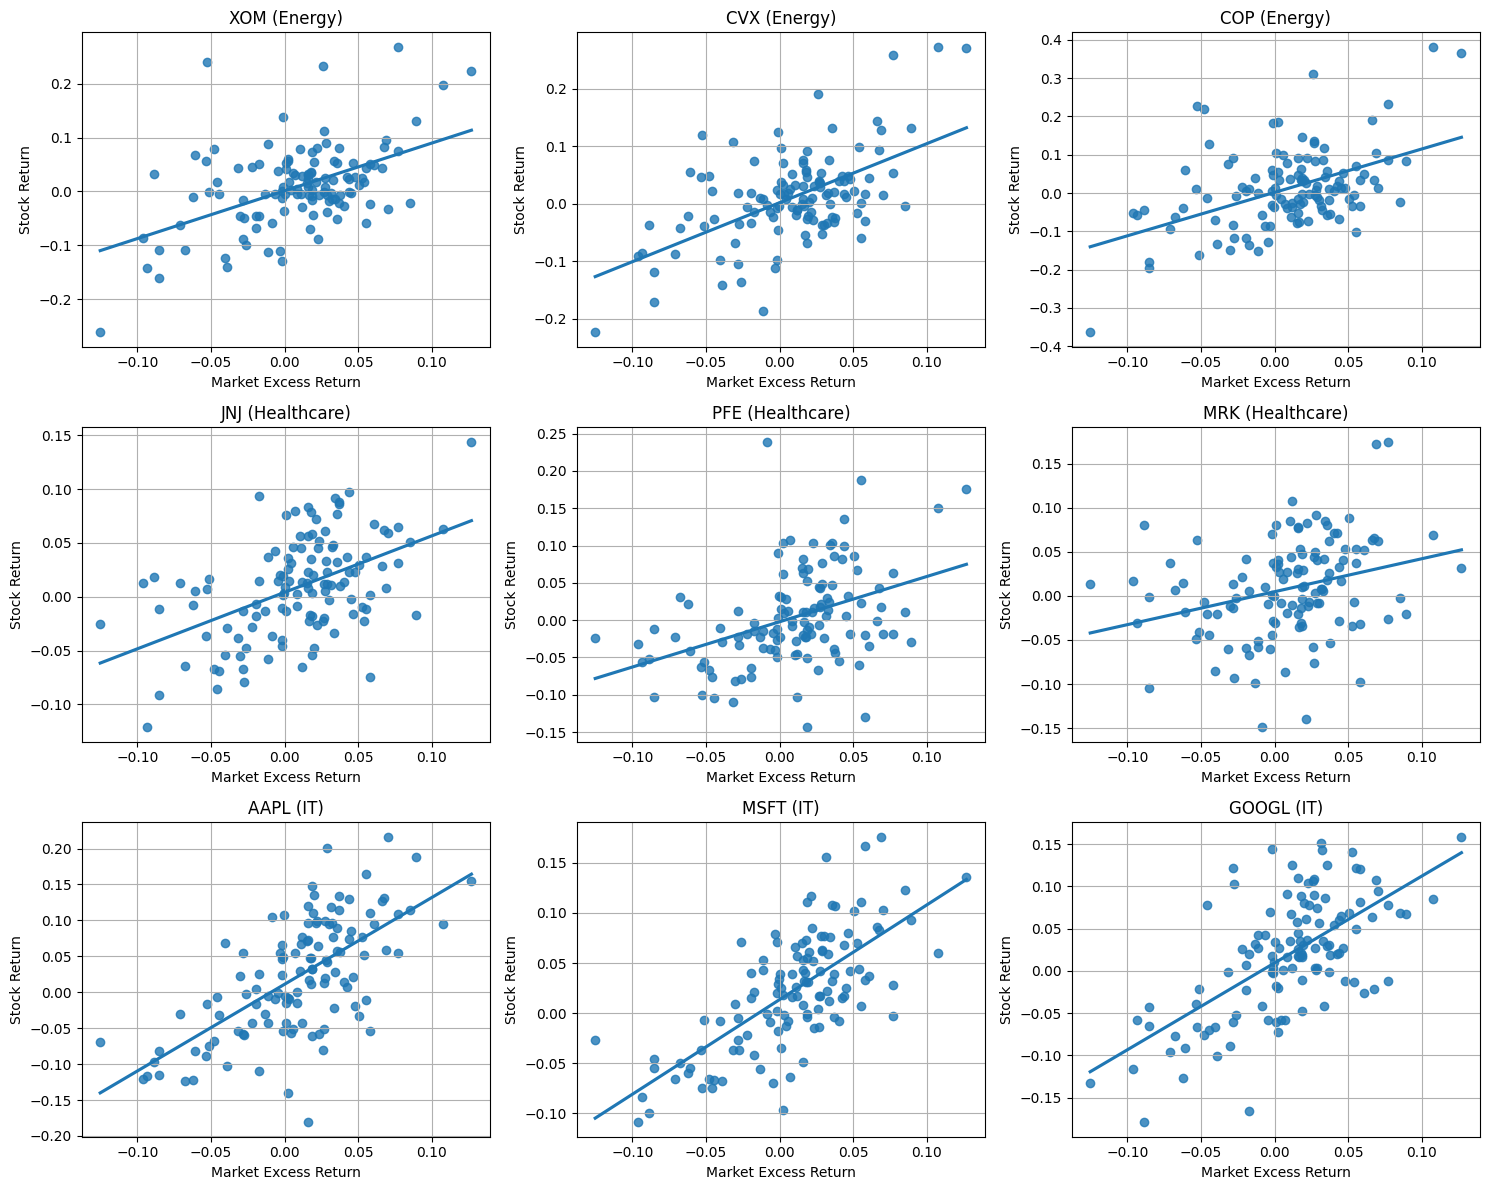

In [40]:
# Determine grid size
n_cols = max(len(stocks) for stocks in tickers.values())  # max stocks in a sector
n_rows = len(tickers)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4), squeeze=False)

for row_idx, (sector, stocks) in enumerate(tickers.items()):
    for col_idx, stock in enumerate(stocks):
        y = data[stock]
        x = data['Market_Excess']

        sns.regplot(x=x, y=y, ci=None, ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(f"{stock} ({sector})")
        axes[row_idx, col_idx].set_xlabel("Market Excess Return")
        axes[row_idx, col_idx].set_ylabel("Stock Return")
        axes[row_idx, col_idx].grid(True)

    # Hide unused subplots in this row
    for empty_col in range(len(stocks), n_cols):
        axes[row_idx, empty_col].set_visible(False)

plt.tight_layout()
plt.show()


All the stocks show a positive correlation with the market excess return, which is expected since most equities move in the same direction as the overall market.

*   Beta (β): Measures the sensitivity of the stock to market movements. A higher beta indicates that the stock tends to amplify market fluctuations. Stocks like [example: MSFT] have higher betas, meaning they are more volatile relative to the market, while more defensive stocks like [example: JNJ] have lower betas.

*   Alpha (α): Measures the average excess return of the stock not explained by market movements. Positive alpha indicates outperformance relative to CAPM, negative alpha indicates underperformance. Most alphas are small, suggesting that the majority of the stock return is explained by market movements.

Overall, the results confirm that the CAPM captures the main linear relationship between stock returns and the market, with scatter plots visually supporting the regression lines.